In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gekko import GEKKO
from sklearn.preprocessing import StandardScaler
import pandas as pd
from joblib import load

In [164]:
from tensorflow import keras
model = keras.models.load_model('/Users/dallinlittlewood/Smart Systems') #Load tensorflow neural network

In [165]:
s=load('std_scaler.bin') #Load scaling MinMaxArray

In [ ]:
m = GEKKO() #Initiate gekko model
nt = 601
t = np.linspace(0,1000,nt)
m.time = t

In [167]:
## Reactor Properties
ρ_b = m.Const(value=200000) #g/m3
D = m.Const(value=1.5/39.37) #m
L = m.Const(value=4*12/39.37) #m
Ac = m.Intermediate(np.pi/4*D**2) #m2
V = m.Intermediate(np.pi/4*D**2*L) #m3
W = m.Intermediate(Ac*L*ρ_b) #weight of catalyst, g
Cp = m.Const(value=3500) #kJ/kg/K
Ua = m.Const(value=45000)

## Syngas Feed
yco = m.Const(0.214) #mole fraction of CO
yh2 = m.Const(0.46) #mole fraction of H2
T0 = m.Const(value= 195 + 273.15) #K

## Kinetics
A = m.Const(value=3.32e7/60) #mol/g/s/atm^0.55
Ea = m.Const(value=93.8) #kJ/mol
ΔHr = m.Const(value=-165) #kJ/mol
R = m.Const(value=8.314e-3) #kJ/mol/K

In [168]:
## Manipulated Variables
Tc = m.MV(value=200+273.15,lb=195+273.15,ub=230+273.15) #Coolant temperature
P = m.MV(value=19.9,lb=17/1.01325,ub=24/1.01325) #atm
q = m.MV(value=2.5,lb=2,ub=6) #SLPM
Recycle = m.MV(value=40,lb=20,ub=50) #SLPM

F0 = m.Intermediate(q/0.082057/273.15/60) #mol/s
Fco = m.Intermediate(F0*yco) #mol/s

Tc.STATUS = 1
Tc.DCOST = 0

P.STATUS = 1
P.DCOST = 0.1 #Don't want pressure to move as much

q.STATUS = 1
q.DCOST = 0

Recycle.STATUS = 1
Recycle.DCOST = 0

T = m.Var(value=196+273.15,lb=195+273.15,ub=215+273.15)

In [169]:
## Equations
Pco = m.Intermediate(P*yco) #partial pressures
Ph2 = m.Intermediate(P*yh2) #partial pressures
r_CO = m.Intermediate(A*m.exp(-Ea/R/T)*Pco**(-0.05)*Ph2**0.6) #rate of CO consumption
#X_CO = m.Intermediate(W*r_CO/Fco)
m.Equation(T.dt() == (-ΔHr)*r_CO/Cp + Ua*(Tc - T)/ρ_b/Cp/V) #energy balance, heat generated minus removed

In [171]:
p = np.zeros(nt)
p[-1] = 1.0
final = m.Param(value=p)

# m.Obj(final*CH4_selec)
m.Obj(-r_CO*final) #maximize rate of CO consumption

In [172]:
m.options.IMODE = 6 #Dynamic optimization

m.solve()

apm 67.177.46.140_gk_model8 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :           12
   Variables    :            6
   Intermediates:            8
   Connections  :            0
   Equations    :           10
   Residuals    :            2
 
 Number of state variables:          13200
 Number of total equations: -        10800
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :           2400
 
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipop

In [173]:
features = ['Tc', 'T', 'Recycle', 'Syngas', 'P']
features2 = ['Tc', 'T', 'Recycle', 'Syngas', 'P', 'CH4 Selec']

data = pd.DataFrame()
data['Tc'] = np.array(Tc.value)-273.15
data['T'] = np.array(T.value)-273.15
data['Recycle'] = np.array(Recycle.value)
data['Syngas'] = np.array(q.value)
data['P'] = np.array(P.value)*1.01325
data['CH4 Selec'] = np.ones(len(t))



data_s = np.transpose(s.scale_x(np.transpose(data[features].to_numpy())))

data_s_df = pd.DataFrame(data_s, columns=features)

data_s_df['CH4 Selec'] = model.predict(data_s_df[features])

data_x = np.transpose(s.unscale_x(np.transpose(data_s_df[features].to_numpy())))
data_y = np.transpose(s.unscale_y(np.transpose(data_s_df['CH4 Selec'].to_numpy())))

data_df = pd.DataFrame(data_x, columns=features)
data_df['CH4 Selec'] = data_y

In [174]:
plt.rc('font',size=18)

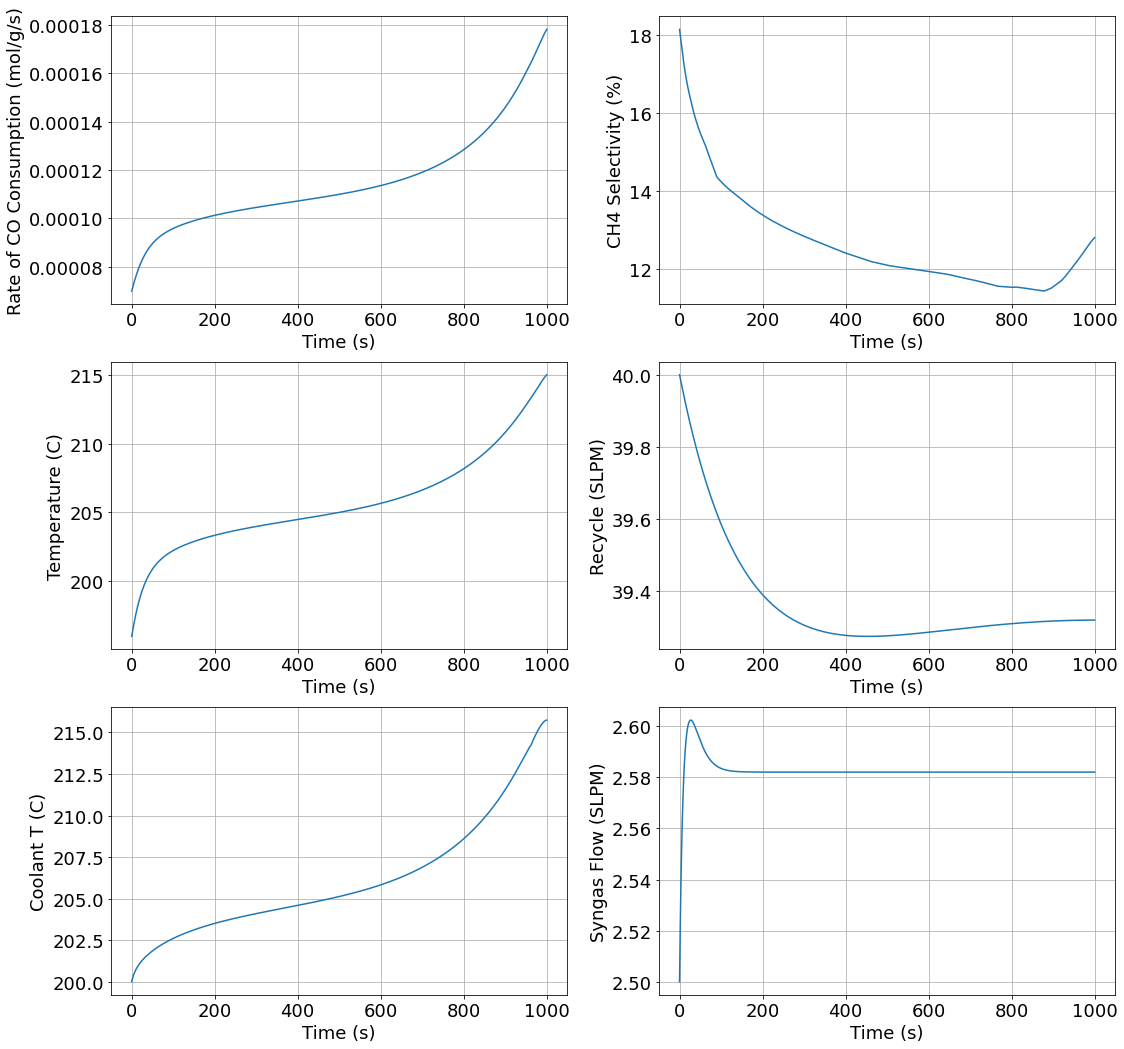

In [175]:
fig,ax = plt.subplots(3,2,figsize=(18, 18))

ax[0,0].plot(m.time,r_CO.value)
ax[0,0].set_xlabel('Time (s)')
ax[0,0].set_ylabel('Rate of CO Consumption (mol/g/s)')
ax[0,0].grid()
ax[0,0].ticklabel_format(useOffset=False, style='plain')

ax[0,1].plot(m.time,data_df['CH4 Selec']*100)
ax[0,1].set_xlabel('Time (s)')
ax[0,1].set_ylabel('CH4 Selectivity (%)')
ax[0,1].grid()
ax[0,1].ticklabel_format(useOffset=False, style='plain')

ax[1,0].plot(m.time,np.array(T.value)-273.15)
ax[1,0].set_xlabel('Time (s)')
ax[1,0].set_ylabel('Temperature (C)')
ax[1,0].grid()
ax[1,0].ticklabel_format(useOffset=False, style='plain')

ax[1,1].plot(m.time,Recycle.value)
ax[1,1].set_xlabel('Time (s)')
ax[1,1].set_ylabel('Recycle (SLPM)')
ax[1,1].grid()
ax[1,1].ticklabel_format(useOffset=False, style='plain')

ax[2,0].plot(m.time,np.array(Tc.value)-273.15)
ax[2,0].set_xlabel('Time (s)')
ax[2,0].set_ylabel('Coolant T (C)')
ax[2,0].grid()
ax[2,0].ticklabel_format(useOffset=False, style='plain')

ax[2,1].plot(m.time,q.value)
ax[2,1].set_xlabel('Time (s)')
ax[2,1].set_ylabel('Syngas Flow (SLPM)')
ax[2,1].grid()
ax[2,1].ticklabel_format(useOffset=False, style='plain')

plt.savefig('results.png')